In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 学习曲线(Learning Curve)

学习曲线显示模型在不同规模的训练数据中的训练和测试成绩关系，发现能否从扩大训练规模中：
* 提高模型成绩
* 改善模型的偏差
* 改善模型的方差

<br>

增加更多的数据是否会继续收敛？

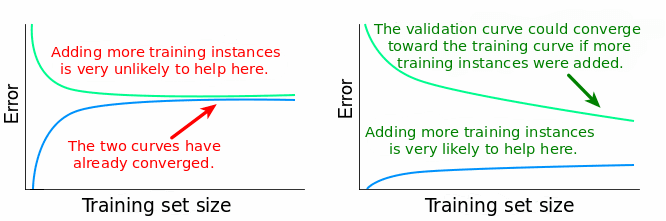

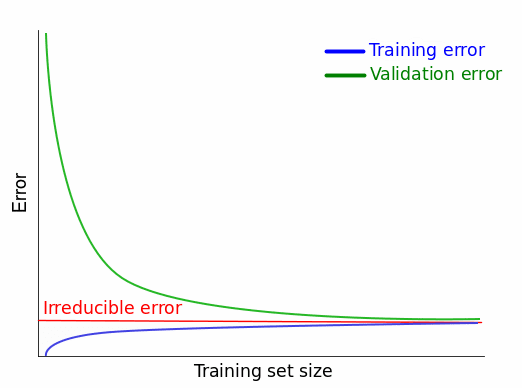

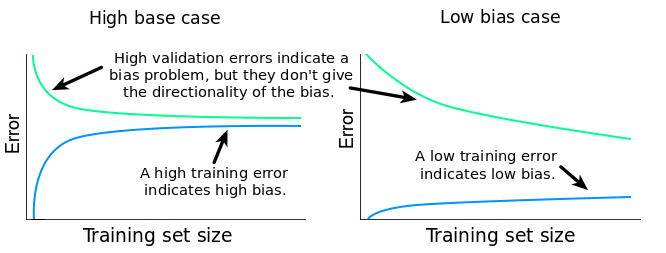

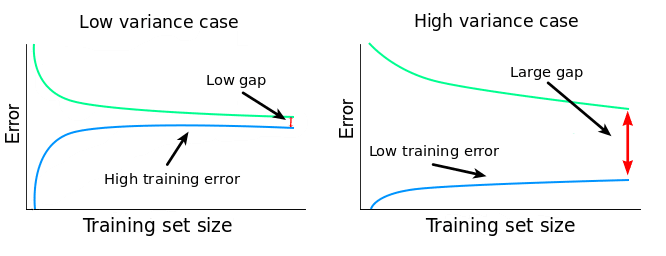

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.model_selection import ShuffleSplit

def iter_param(params):
    for vals in list(zip(*(val for val in params.values()))):
        yield dict(zip(params.keys(), vals))
        
def fit_models(model, X, y, params, cv, train_sizes, n_splits = 30):

    model_params = list(iter_param(params))

    n_model = len(model_params)
    n_part = train_sizes.shape[0]

    model_train_scores = np.zeros((n_model, n_part, cv.n_splits))
    model_test_scores = np.zeros((n_model, n_part, cv.n_splits))
    for i, params in enumerate(model_params):
        model.set_params(**params)
        _, train_scores, test_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=cv, n_jobs=-1)
        model_train_scores[i,:,:] = train_scores
        model_test_scores[i,:,:] = test_scores
        
    return model_train_scores, model_test_scores

def plot_learning_curve(train_scores, test_scores, train_sizes, titles=None):
    n_model = train_scores.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=n_model, figsize=(20, 4), sharey=True, dpi=120)
    for i in range(n_model):
        ax = axes[i]
        model_train_scores, model_test_scores = train_scores[i], test_scores[i]
        disp = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores[i], test_scores=test_scores[i])
        disp.plot(ax=ax, score_type="both", line_kw=dict(marker="o"))
        
        if titles and hasattr(titles, "__getitem__"): 
            ax.set_title(titles[i])
            
        ax.get_legend().remove()
        xticks = np.linspace(0.2, 1, num=5, endpoint=True)
        ax.set_xticks(train_sizes, labels=[f"{x*100:0.0f}%" for x in train_sizes], fontsize=10)
        ax.set_xlim(train_sizes[0] - 0.1, train_sizes[-1] + 0.1)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.grid(axis="y", lw=0.5, ls="-", alpha=0.8)

    handles, label = axes[0].get_legend_handles_labels()
    axes[-1].legend(handles[:2], ["Training", "Testing"], loc="lower right")

    plt.subplots_adjust(wspace=0);

def plot_complexity_curve(train_scores, test_scores):    
    n_model, n_part, n_splits = train_scores.shape
    train_mean, train_std = train_scores.mean(axis=2), train_scores.std(axis=2)
    test_mean, test_std = test_scores.mean(axis=2), test_scores.std(axis=2)

    model_idx = np.arange(n_model)

    fig, axes = plt.subplots(nrows=1, ncols=n_part, figsize=(20, 4), sharey=True, dpi=120)
    for i in range(n_part):
        ax = axes[i]
        model_train_mean, model_train_std = train_mean[:,i], train_std[:,i]
        model_test_mean, model_test_std = test_mean[:,i], test_std[:,i]

        y1 = model_train_mean - model_train_std
        y2 = model_train_mean + model_train_std
        ax.fill_between(model_idx, y1, y2, color='C0', alpha=0.5)
        ax.plot(model_train_mean, c="C0", marker="o", label="Training")

        y1 = model_test_mean - model_test_std
        y2 = model_test_mean + model_test_std
        ax.fill_between(model_idx, y1, y2, color='C1', alpha=0.5)
        ax.plot(model_test_mean, c="C1", marker="o", label="Testing")
        ax.set_title(f"{train_sizes[i]*100:0.0f}% samples")
        ax.grid(axis="y", lw=0.5, ls="-", alpha=0.8)
        ax.set_xticks(model_idx, labels=[f"m{i + 1}" for i in model_idx])
        ax.set_xlim(model_idx[0] - 0.5, model_idx[-1] + 0.5)

    axes[-1].legend(loc="lower right")
    plt.subplots_adjust(wspace=0);

从手写数字$8\times 8$像素数据学习识别数字9。训练实验：
* 一组候选模型，复杂性从低到高
* 将原本样本数据分6组不同数量的样本数据，按照前10%、前28%、前46%、前64%、前82%以及全部样本等6组。
* 针对每个模型、每组数据样本，按照25%比例随机抽样划分测试和训练集，产生30份划分。

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, (digits.target == 9).astype(int)

In [5]:
from sklearn.tree import DecisionTreeClassifier

train_sizes = np.linspace(0.1, 1.0, 6)
cv = ShuffleSplit(n_splits=30, test_size=0.25, random_state=42)

model = DecisionTreeClassifier()
params = {
    "max_depth": [1, 2, 3, 5, 8, 10]
}

train_scores, test_scores = fit_models(model, X, y, params=params, train_sizes=train_sizes, cv=cv)

In [40]:
train_scores.shape

(6, 6, 30)

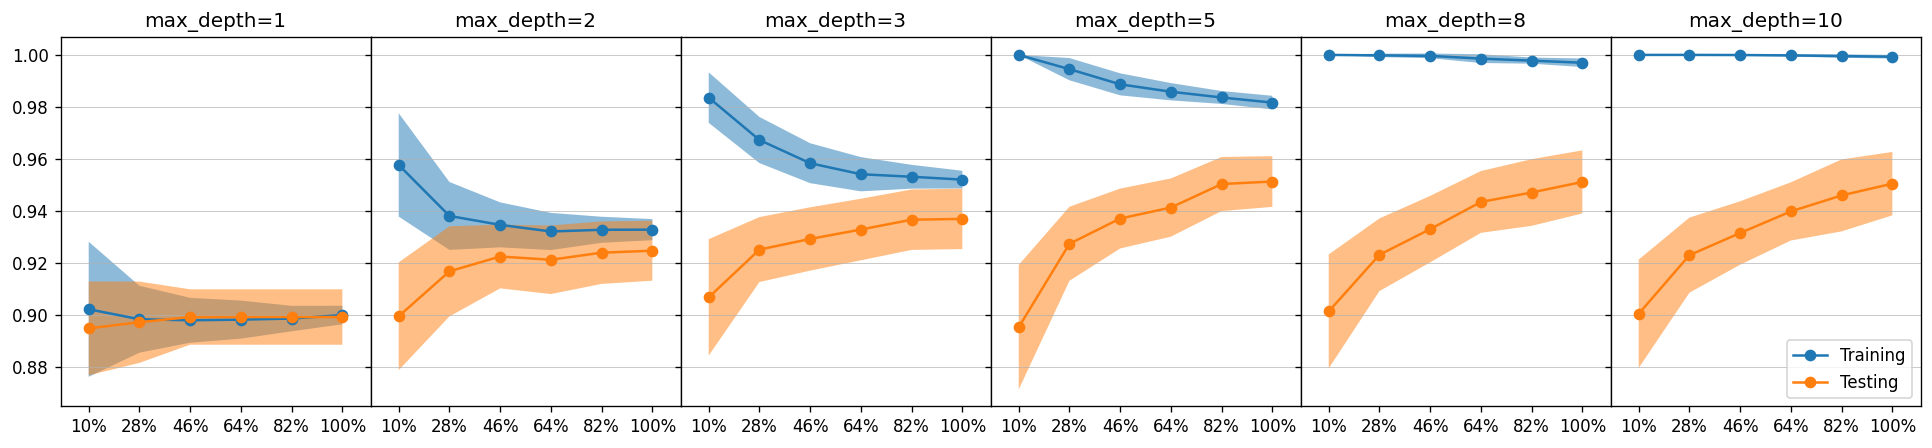

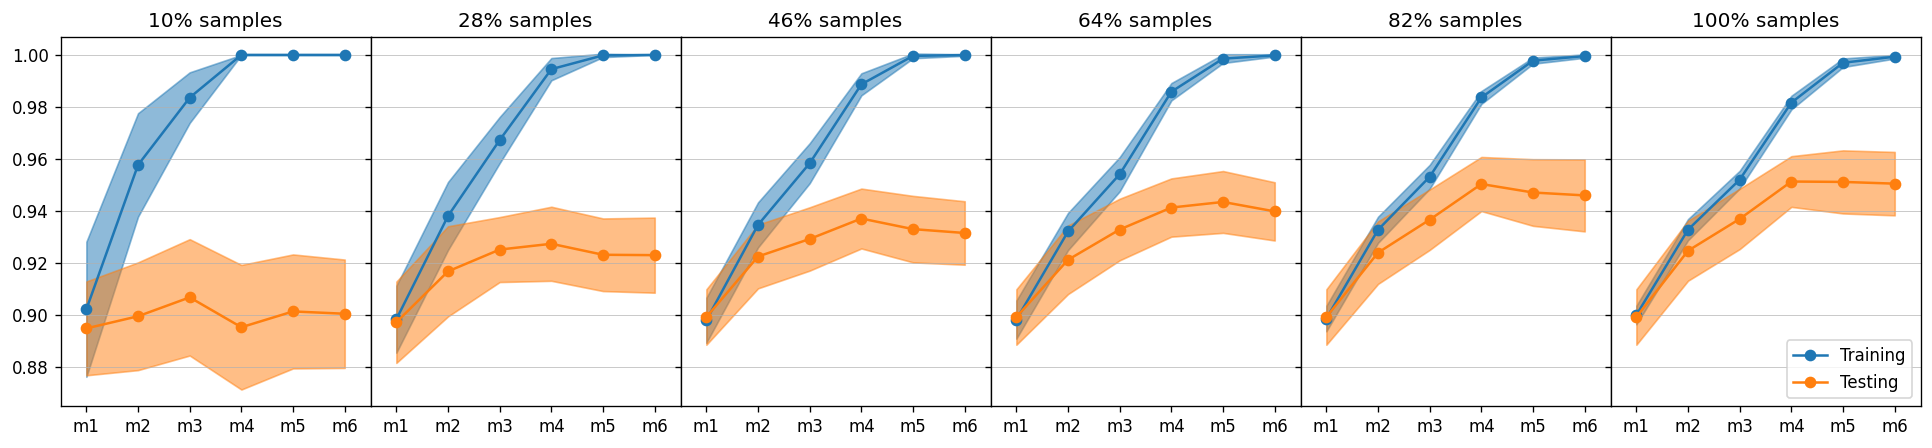

In [6]:
titles = [" ".join([f"{k}={v}" for k, v in d.items()]) for d in iter_param(params)]
plot_learning_curve(train_scores, test_scores, train_sizes, titles=titles)
plot_complexity_curve(train_scores, test_scores)

In [44]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, (digits.target == 9).astype(int)

from sklearn.svm import SVC
model = SVC(kernel="rbf")

train_sizes = np.linspace(0.1, 1.0, 6)
cv = ShuffleSplit(n_splits=30, test_size=0.25, random_state=42)

params = {
    "C": np.repeat(100, 5), 
    "gamma": [0.01, 0.008, 0.005, 0.003, 0.001]
}

train_scores, test_scores = fit_models(model, X, y, params=params, train_sizes=train_sizes, cv=cv)

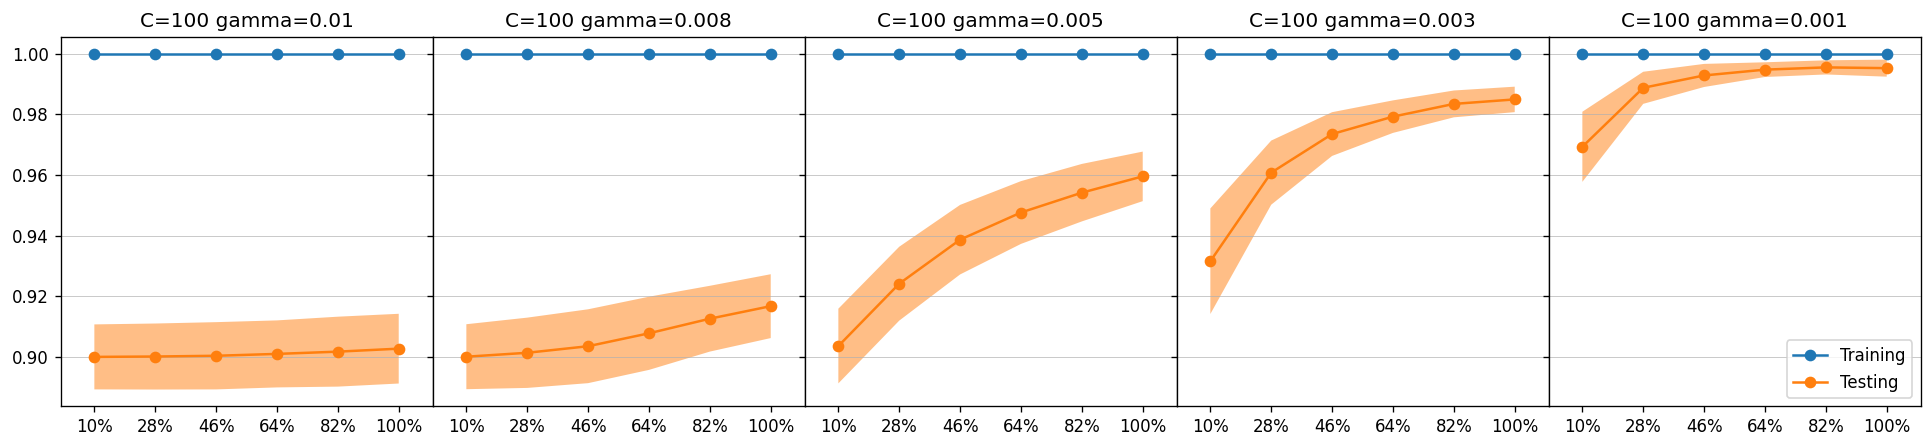

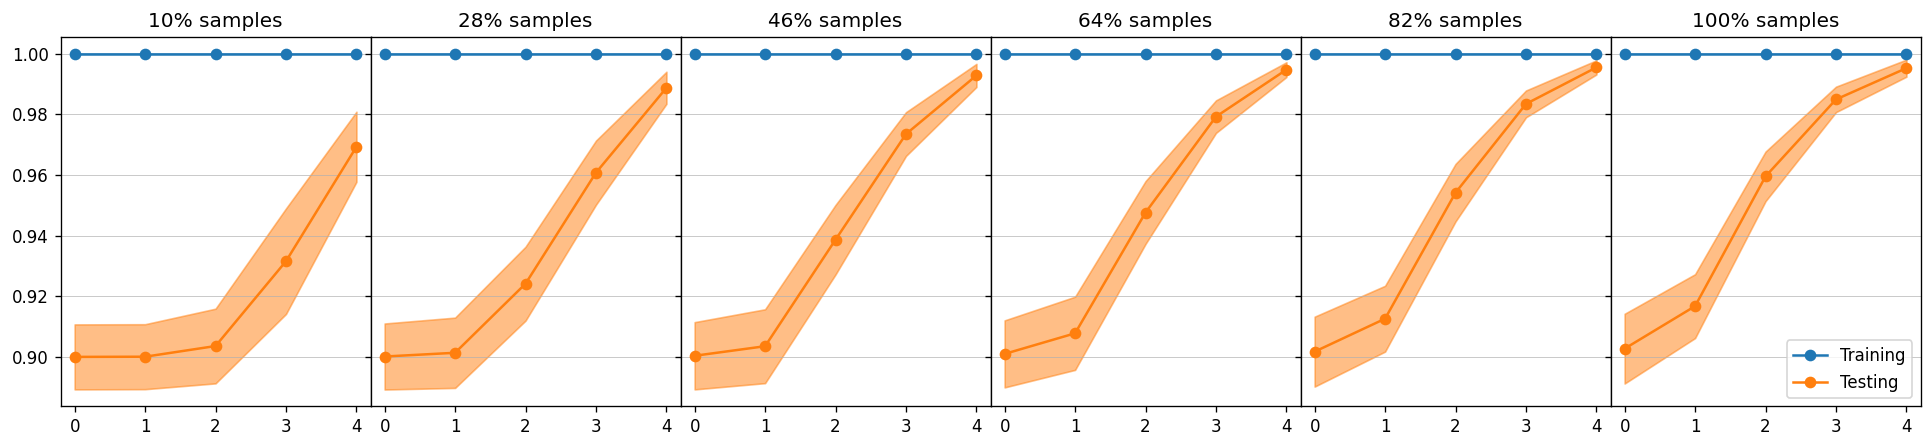

In [7]:
titles = [" ".join([f"{k}={v}" for k, v in d.items()]) for d in iter_param(params)]
plot_learning_curve(train_scores, test_scores, train_sizes, titles=titles)
plot_complexity_curve(train_scores, test_scores)

In [42]:
from sklearn.svm import SVC
model = SVC(kernel="rbf")

train_sizes = np.linspace(0.1, 1.0, 6)
cv = ShuffleSplit(n_splits=30, test_size=0.25, random_state=42)

params = {
    "C": [1, 4, 10, 50, 1000], 
    "gamma": np.repeat(0.0001, 5)
}

train_scores, test_scores = fit_models(model, X, y, params=params, train_sizes=train_sizes, cv=cv)

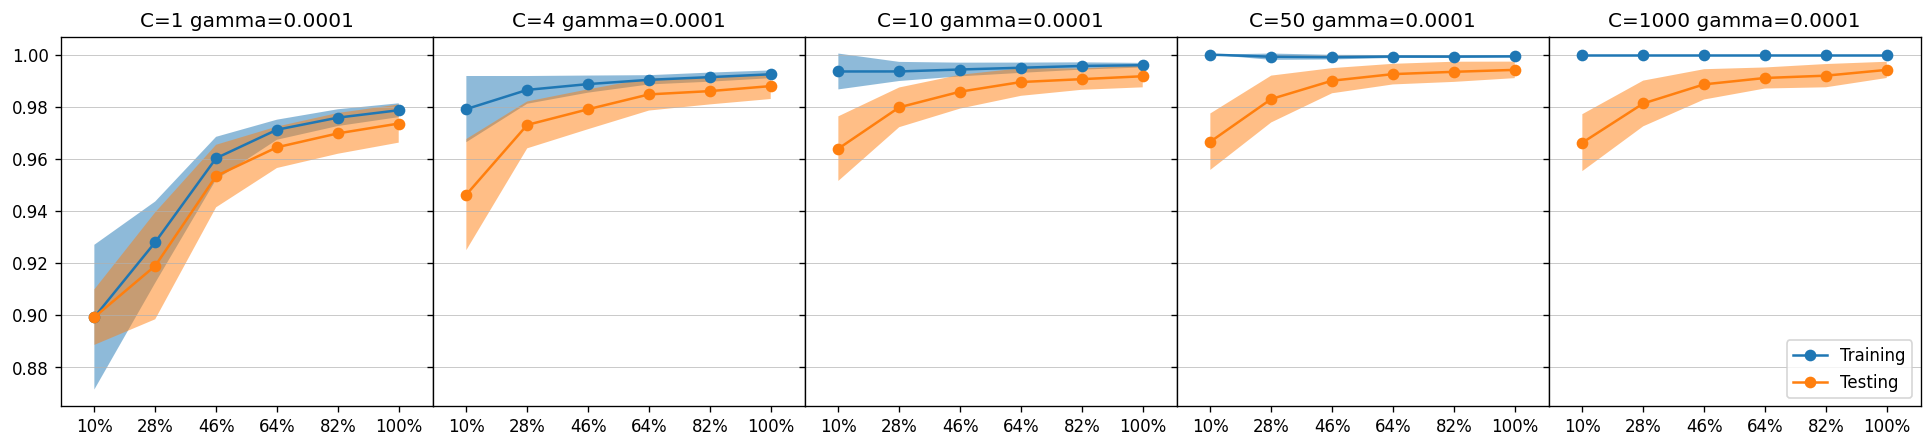

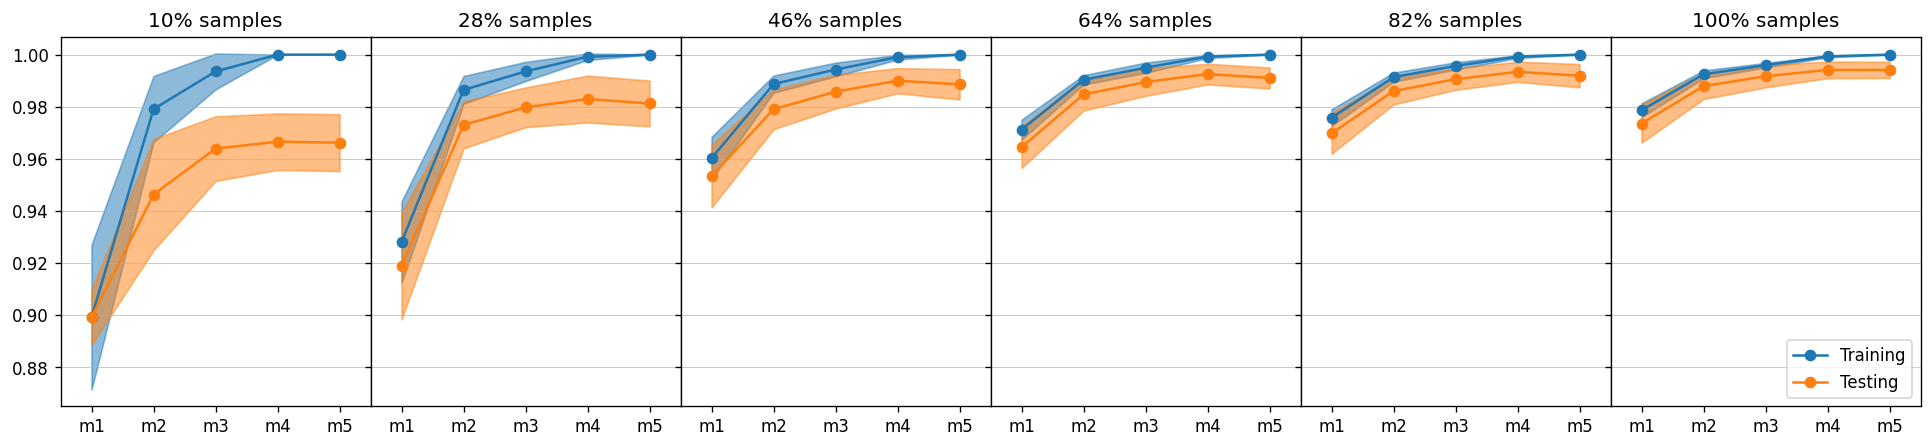

In [43]:
titles = [" ".join([f"{k}={v}" for k, v in d.items()]) for d in iter_param(params)]
plot_learning_curve(train_scores, test_scores, train_sizes, titles=titles)
plot_complexity_curve(train_scores, test_scores)